# Vector field plottings 

In [3]:
import numpy as np 
import plotter # my 3d plotting code with plotly
import matplotlib.pyplot as plt 

## Two Example Fields and Call Sequences

In [4]:
# Define grid
x1, y1, z1 = np.meshgrid(
    np.linspace(-1, 1, 5),
    np.linspace(-1, 1, 5),
    np.linspace(-1, 1, 5)
)

# Simple radial field example 
u1 = x1
v1 = y1
w1 = z1

plotter.plotter(x1, y1, z1, u1, v1, w1)

In [5]:
x2, y2, z2 = np.meshgrid(np.arange(-0.8, 1, 0.2),
                      np.arange(-0.8, 1, 0.2),
                      np.arange(-0.8, 1, 0.8))

u2 = np.sin(np.pi * x2) * np.cos(np.pi * y2) * np.cos(np.pi * z2) 
v2 = -np.cos(np.pi * x2) * np.sin(np.pi * y2) * np.cos(np.pi * z2) 
w2 = (np.sqrt(2.0 / 3.0) * np.cos(np.pi * x2) * np.cos(np.pi * y2) * np.sin(np.pi * z2)) 

plotter.plotter(x2, y2, z2, u2, v2, w2)

clear to me that some refinement needs doing on the plotting code so that we can see the underlying fields a lot clearer. This will be done in time

## Generating Physics Related Vector Fields

This is for the purpose of later having things to compare to. Possible examples of reasonable fields include:
- field around 1d solenoid
- bar magnet? 

Plan is to make use of boundary conditions. If we have certain circumstances in which one field may be continuous but the other is not, then by allowing communication between these two can lead to accurate fields being derived for aggregate scenarios. 

In [6]:
from constants import CONSTANTS  # handy place to lump all of these and avoid typos 

In [7]:
def field_around_current_carrying_wire(I:float, 
                                       CONSTANTS:dict, 
                                       x_extent:list = [-5, 5], 
                                       y_extent:list = [-5, 5],
                                       z_extent:list = [5,-5], 
                                       resolution:float = 10) -> list[np.ndarray]:
    '''
    A current carrying wire will have a magnetic field around it. The wire will run parallel to the z
    axis, and be placed at the origin of the x,y plane. Current will be travelling in the direction of positive z.

    Direction of the current is dependent on the direction of travel. When it comes time to compare these outputs 
    to that of the GP, we can crank up the resolution of this and see if it can recreate the field.
    
    Args:
        I (float): Current which the wire is carrying.
        CONSTANTS (dict): Dictionary of all of the physical constants which could be useful.

        x_extent (list[int]): extent in the x direction of the final field. In SI Units, this will be meters.
        y_extent (list[int]): extent in the y direction of the final field. In SI Units, this will be meters.
        z_extent (list[int]): extent in the z direction of the final field. In SI Units, this will be meters.

    Returns:
        6 numpy nd arrays 
    '''
    x, y, z = np.meshgrid(
        np.linspace(x_extent[0], x_extent[1], resolution),
        np.linspace(y_extent[0], y_extent[1], resolution),
        np.linspace(z_extent[0], z_extent[1], resolution)
    )

    r = np.sqrt(x**2 + y**2) + 1e-3  # avoid div by zero
    theta = np.arctan2(y, x)

    feild_strength = CONSTANTS["mu_naught"] * I / (2 * CONSTANTS["pi"])

    u = -feild_strength / r * np.sin(theta)
    v = feild_strength / r * np.cos(theta)
    w = np.zeros_like(z)

    return x, y, z, u, v, w

# call
x, y, z, u, v, w = field_around_current_carrying_wire(0.0001,CONSTANTS)
plotter.plotter(x, y, z, u, v, w)

In [15]:
def field_around_toroidal_current_carrying_wire(I:float, 
                                                ring_radius:float = 0.5,
                                                CONSTANTS:dict = CONSTANTS, 
                                                x_extent:list = [-2, 2], 
                                                y_extent:list = [-2, 2],
                                                z_extent:list = [2,-2], 
                                                resolution:float = 26, 
                                                integral_discretisation:float = 1000) -> list[np.ndarray]:
    '''
    In the case of a circulating current, a magnetic field is formed inside of it. This is a nice parity to the previous case. 
    We will place our coil in the centre of the x,y plane, with current circulating anticlockwise as you look at it down the z 
    axis. By the right hand rule, this will lead to a magnetic field which is aligned directly up the z axis. 
    
    Args:
        I (float): Current which the wire is carrying.
        ring_radius (float): Radius of our current carrying ring
        CONSTANTS (dict): Dictionary of all of the physical constants which could be useful.
        x_extent (list[int]): extent in the x direction of the final field. In SI Units, this will be meters.
        y_extent (list[int]): extent in the y direction of the final field. In SI Units, this will be meters.
        z_extent (list[int]): extent in the z direction of the final field. In SI Units, this will be meters.
        resolution (int): side length of rectangular grid
        integral_discretisation (int): how many segments we break up our integral into.

    Returns:
        6 numpy nd arrays 
    '''
    mu0, Pi = CONSTANTS['mu_naught'], CONSTANTS['pi']


    x, y, z = np.meshgrid(
        np.linspace(x_extent[0], x_extent[1], resolution),
        np.linspace(y_extent[0], y_extent[1], resolution),
        np.linspace(z_extent[0], z_extent[1], resolution)
    )
    Bx, By, Bz = np.zeros_like(x), np.zeros_like(y), np.zeros_like(z)


    # Biot–Savart prefactor
    prefactor = mu0 * I / (4*Pi)
    
    # Discretise the loop into large number of pieces for summation approximation 
    dphi = 2*np.pi / integral_discretisation
    phis = np.linspace(0, 2*Pi, integral_discretisation, endpoint=False)
    
    for phi in phis:
        # Coordinates of the source point on the loop
        xprime = ring_radius*np.cos(phi)
        yprime = ring_radius*np.sin(phi)
        zprime = 0.0
        
        # d\ell' = ( -R sin(phi), R cos(phi), 0 ) * dphi
        dlx = -ring_radius * np.sin(phi) * dphi
        dly =  ring_radius * np.cos(phi) * dphi
        dlz =  0.0
        
        # r - r'
        rx = x - xprime
        ry = y - yprime
        rz = z - zprime
        
        # distance^3 (have to add small amount for numerical stability )
        r3 = (rx**2 + ry**2 + rz**2)**1.5 + 0.01  
        
        # cross product dl' x (r-r'):
        cross_x = dly*rz - dlz*ry  # = R cos(phi)*z * dphi
        cross_y = dlz*rx - dlx*rz  # = R sin(phi)*z * dphi
        cross_z = dlx*ry - dly*rx  # more complicated, see formula
       
        # Accumulate in B
        Bx += prefactor * cross_x / r3
        By += prefactor * cross_y / r3
        Bz += prefactor * cross_z / r3

    return x, y, z, Bx, By, Bz
# call
x, y, z, fields_x, fields_y, fields_z = field_around_toroidal_current_carrying_wire(1)
plotter.plotter(x, y, z, fields_x, fields_y, fields_z) 

In [9]:
def field_around_infinite_solenoid(I:float, 
                                   CONSTANTS:dict, 
                                   x_extent:list = [-5, 5], 
                                   y_extent:list = [-5, 5],
                                   z_extent:list = [5,-5], 
                                   resolution:float = 10) -> list[np.ndarray]:
    '''
    To extend the previous case, we can also model an infinite current carrying solenoid, parallel to the z axis. 
    This is also a case for which the analytical solution is known exactly and hence offers a nice playground to 
    test the GP methods. 

    Will be interesting for investigating the tail behaviour of the GPs fitted field. 

    Args:
        I (float): Current which the wire is carrying.
        CONSTANTS (dict): Dictionary of all of the physical constants which could be useful.

        x_extent (list[int]): extent in the x direction of the final field. In SI Units, this will be meters.
        y_extent (list[int]): extent in the y direction of the final field. In SI Units, this will be meters.
        z_extent (list[int]): extent in the z direction of the final field. In SI Units, this will be meters.

    Returns:
        6 numpy nd arrays 
    '''
    pass

In [16]:
fields_z_trimmed = fields_z[(fields_x == 0) & (fields_y == 0)]

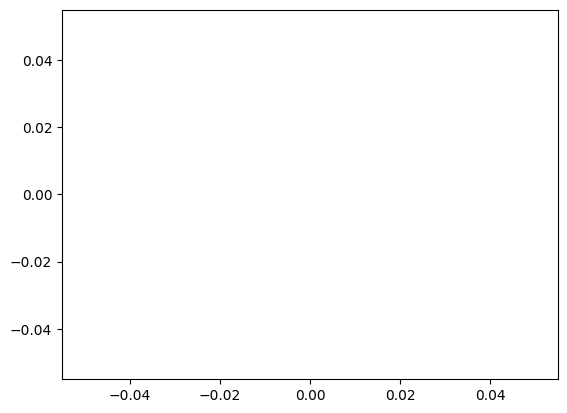

In [17]:
plt.plot(fields_z_trimmed)

In [ ]:
len(fields_z_trimmed)

441